# Model Selection and Final Results For Multiple Authors

## Importing the necessary packages

In [155]:
import pandas as pd
from src.model import LexicalFeatures, BOWFeatures, SyntacticFeatures, NGramFeatures
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, MaxAbsScaler
from mlxtend.classifier import EnsembleVoteClassifier

processed_data = str('./../data/processed/')

## Importing the processed data files

In [115]:
train_df = pd.read_csv(processed_data+'training_set.csv')

valid_df1 = pd.read_csv(processed_data+'validation_set_1.csv')
valid_df2 = pd.read_csv(processed_data+'validation_set_2.csv')
valid_df3 = pd.read_csv(processed_data+'validation_set_3.csv')
valid_df4 = pd.read_csv(processed_data+'validation_set_4.csv')

valid_df_list = [valid_df1, valid_df2, valid_df3, valid_df4]

test_df1 = pd.read_csv(processed_data+'test_set_1.csv')
test_df2 = pd.read_csv(processed_data+'test_set_2.csv')
test_df3 = pd.read_csv(processed_data+'test_set_3.csv')
test_df4 = pd.read_csv(processed_data+'test_set_4.csv')

test_df_list = [test_df1, test_df2, test_df3, test_df4]

### Label Encode the author list in the training set

In [116]:
le = LabelEncoder()
train_target = le.fit_transform(train_df['author'])

## Defining the model pipelines

### Bag Of Words (BOW) Pipeline

In [117]:
bow_pipe = Pipeline([('features', Pipeline([
                              ('create', BOWFeatures()),
                              ('scale', MaxAbsScaler())
                              ])
                          ),
                         ('classifier', LogisticRegression(max_iter = 500, C = 100))])

### Syntactic Pipeline

In [118]:
clf = SVC(C=750.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
    max_iter=-1, probability=True, shrinking=True, tol=0.001,
    verbose=False)

syntactic_pipe = Pipeline([('features', Pipeline([
                              ('create', SyntacticFeatures()),
                              ('scale', MaxAbsScaler())
                              ])
                          ),
                         ('classifier', clf)])

### Lexical Pipeline

In [119]:
lexical_pipe = Pipeline([('features', Pipeline([
                              ('build', LexicalFeatures()),
                              ('scale', StandardScaler())
                              ])
                          ),
                         ('svc', SVC(C = 750, gamma = 0.0175, probability=True))])

### N-Gram Pipeline

In [120]:
ngram_pipe = Pipeline([('features', Pipeline([('build', NGramFeatures()),
                              ('scale', StandardScaler())
                              ])
                          ),
                         ('svc', SVC(C = 750, gamma = 0.0175, probability=True))])

## Voter Ensembles

Here, we want to find out which combination of pipelines work best. We will validate various combinations on the 4 validation sets, and choose the combination which performs the best. The pipelines will be combined by a 'soft' ensemble-voting classifier.

### Voter 1 (BOW)

In [121]:
bow_pipe.fit(train_df['text'], train_target)

Pipeline(memory=None,
         steps=[('features',
                 Pipeline(memory=None,
                          steps=[('create',
                                  BOWFeatures(bow={'aaaaahed': 12155,
                                                   'aaah': 16715,
                                                   'aargh': 16243, 'ab': 6259,
                                                   'abace': 14732,
                                                   'aback': 5080,
                                                   'abandon': 672,
                                                   'abandoning': 16599,
                                                   'abandonment': 9900,
                                                   'abart': 13276,
                                                   'abasement': 9850,
                                                   'abash': 5494, 'abate': 627,
                                                   'abatement': 6950,
                    

In [122]:
v1_score = []
for valid in valid_df_list:
    score = bow_pipe.score(valid['text'], le.transform(valid['author']))
    v1_score.append(score)
v1_score

[0.8791666666666667, 0.8666666666666667, 0.85, 0.8916666666666667]

### Voter 2 (Lexical)

In [123]:
lexical_pipe.fit(train_df['text'], train_target)

Pipeline(memory=None,
         steps=[('features',
                 Pipeline(memory=None,
                          steps=[('build',
                                  LexicalFeatures(include_all_features=True)),
                                 ('scale',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True))],
                          verbose=False)),
                ('svc',
                 SVC(C=750, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.0175, kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [124]:
v2_score = []
for valid in valid_df_list:
    score = lexical_pipe.score(valid['text'], le.transform(valid['author']))
    v2_score.append(score)
v2_score

[0.43333333333333335,
 0.4083333333333333,
 0.4166666666666667,
 0.39166666666666666]

### Voter 3 (Syntactic)

In [125]:
syntactic_pipe.fit(train_df['text'], train_target)

Pipeline(memory=None,
         steps=[('features',
                 Pipeline(memory=None,
                          steps=[('create', SyntacticFeatures()),
                                 ('scale', MaxAbsScaler(copy=True))],
                          verbose=False)),
                ('classifier',
                 SVC(C=750.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.02,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [126]:
v3_score = []
for valid in valid_df_list:
    score = syntactic_pipe.score(valid['text'], le.transform(valid['author']))
    v3_score.append(score)
v3_score

[0.6875, 0.6541666666666667, 0.6708333333333333, 0.6666666666666666]

### Voter 4 (NGram)

In [127]:
ngram_pipe.fit(train_df['text'], train_target)

Pipeline(memory=None,
         steps=[('features',
                 Pipeline(memory=None,
                          steps=[('build',
                                  NGramFeatures(ngrams=[(1, True, True),
                                                        (2, True, True),
                                                        (3, True, True)])),
                                 ('scale',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True))],
                          verbose=False)),
                ('svc',
                 SVC(C=750, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.0175, kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [128]:
v4_score = []
for valid in valid_df_list:
    score = ngram_pipe.score(valid['text'], le.transform(valid['author']))
    v4_score.append(score)
v4_score

[0.3958333333333333, 0.4, 0.42916666666666664, 0.4083333333333333]

## Mixed Voting Performances

### Voter5 (BOW&Lexical)

In [129]:
v5 = EnsembleVoteClassifier(clfs=[bow_pipe, lexical_pipe], voting='soft', refit=False)
v5.fit(train_df['text'], train_target)
v5_score = []
for valid in valid_df_list:
    score = v5.score(valid['text'], le.transform(valid['author']))
    v5_score.append(score)
v5_score

[0.875, 0.8541666666666666, 0.7916666666666666, 0.85]

### Voter6 (BOW&Syntactic)

In [130]:
v6 = EnsembleVoteClassifier(clfs=[bow_pipe, syntactic_pipe], voting='soft', refit=False)
v6.fit(train_df['text'], train_target)
v6_score = []
for valid in valid_df_list:
    score = v6.score(valid['text'], le.transform(valid['author']))
    v6_score.append(score)
v6_score

[0.8791666666666667,
 0.8708333333333333,
 0.8541666666666666,
 0.8916666666666667]

### Voter7 (BOW&NGram)

In [131]:
v7 = EnsembleVoteClassifier(clfs=[bow_pipe, ngram_pipe], voting='soft', refit=False)
v7.fit(train_df['text'], train_target)
v7_score = []
for valid in valid_df_list:
    score = v7.score(valid['text'], le.transform(valid['author']))
    v7_score.append(score)
v7_score

[0.8958333333333334, 0.8833333333333333, 0.8708333333333333, 0.9]

### Voter8 (BOW&Lexical&Syntactic)

In [132]:
v8 = EnsembleVoteClassifier(clfs=[bow_pipe, lexical_pipe, syntactic_pipe], voting='soft', refit=False)
v8.fit(train_df['text'], train_target)
v8_score = []
for valid in valid_df_list:
    score = v8.score(valid['text'], le.transform(valid['author']))
    v8_score.append(score)
v8_score

[0.8833333333333333, 0.8916666666666667, 0.8375, 0.8916666666666667]

### Voter9 (BOW&Lexical&NGram)

In [133]:
v9 = EnsembleVoteClassifier(clfs=[bow_pipe, lexical_pipe, ngram_pipe], voting='soft', refit=False)
v9.fit(train_df['text'], train_target)
v9_score = []
for valid in valid_df_list:
    score = v9.score(valid['text'], le.transform(valid['author']))
    v9_score.append(score)
v9_score

[0.8875, 0.8541666666666666, 0.8041666666666667, 0.8291666666666667]

### Voter10 (BOW&Syntactic&NGram)

In [134]:
v10 = EnsembleVoteClassifier(clfs=[bow_pipe, syntactic_pipe, ngram_pipe], voting='soft', refit=False)
v10.fit(train_df['text'], train_target)
v10_score = []
for valid in valid_df_list:
    score = v10.score(valid['text'], le.transform(valid['author']))
    v10_score.append(score)
v10_score

[0.9, 0.8875, 0.8708333333333333, 0.8916666666666667]

### Voter11 (BOW&Lexical&Syntactic&NGram)

In [135]:
v11 = EnsembleVoteClassifier(clfs=[bow_pipe, lexical_pipe, syntactic_pipe, ngram_pipe], voting='soft', refit=False)
v11.fit(train_df['text'], train_target)
v11_score = []
for valid in valid_df_list:
    score = v11.score(valid['text'], le.transform(valid['author']))
    v11_score.append(score)
v11_score

[0.8833333333333333, 0.875, 0.8541666666666666, 0.8791666666666667]

### Box Plot

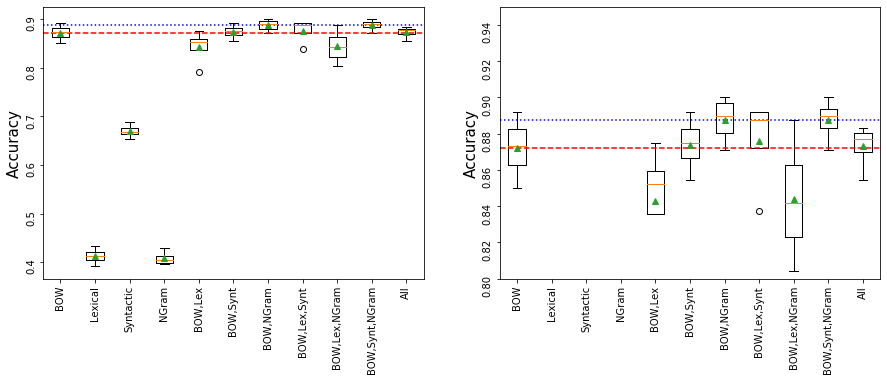

In [181]:
names = ['BOW', 'Lexical', 'Syntactic', 'NGram', 'BOW,Lex', 'BOW,Synt', 'BOW,NGram', 'BOW,Lex,Synt', 'BOW,Lex,NGram', 'BOW,Synt,NGram', 'All']
results = [v1_score, v2_score, v3_score, v4_score, v5_score, v6_score, v7_score, v8_score, v9_score, v10_score, v11_score]
fig, ax = plt.subplots(1,2,figsize = (15,5),sharey=False)

ax1 = ax[0]
ax1 = plt.subplot(121)
ax1.boxplot(results, labels=names, showmeans=True)
ax1.axhline(y=np.mean(v1_score), color='r', linestyle='--')
ax1.axhline(y=np.mean(v10_score), color='b', linestyle=':')
ax1.set_ylabel("Accuracy", fontsize=15)
ax1.tick_params(labelrotation=90)

ax2 = ax[1]
ax2 = plt.subplot(122)
ax2.boxplot(results, labels=names, showmeans=True)
ax2.axhline(y=np.mean(v1_score), color='r', linestyle='--')
ax2.axhline(y=np.mean(v7_score), color='b', linestyle=':')
ax2.set_ylabel("Accuracy", fontsize=15)
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0.8,0.95)
plt.show()

In [148]:
print ("Voter", "Mean", "Std.")
for i, score in enumerate(results):
    print(i+1, round(np.mean(score),3), round(np.std(score),3))

Voter Mean Std.
1 0.872 0.015
2 0.412 0.015
3 0.67 0.012
4 0.408 0.013
5 0.843 0.031
6 0.874 0.014
7 0.888 0.011
8 0.876 0.023
9 0.844 0.031
10 0.888 0.011
11 0.873 0.011


## Final Result

The books used in the test sets are new and have not been trained on before.

### Calculating the confusion matrices and accuracies

In [139]:
confusion_mat = []
accuracy = []

for i in range(4):
    cmat = confusion_matrix(le.transform(test_df_list[i]['author']), v10.predict(test_df_list[i]['text']), 
                            normalize= 'true')
    acc = v10.score(test_df_list[i]['text'], le.transform(test_df_list[i]['author']))
    confusion_mat.append(cmat)
    accuracy.append(acc)

### Accuracy for the sets are printed here.

In [140]:
for i, acc in enumerate(accuracy):
    print ("For testing set", i, ", the accuracy is", acc)

For testing set 0 , the accuracy is 0.9
For testing set 1 , the accuracy is 0.8875
For testing set 2 , the accuracy is 0.8916666666666667
For testing set 3 , the accuracy is 0.8625


### Plotting the confusion matrices

['austen' 'carroll' 'defoe' 'dickens' 'doyle' 'london' 'rowling' 'shelley'
 'stevenson' 'twain' 'wells' 'wilde']


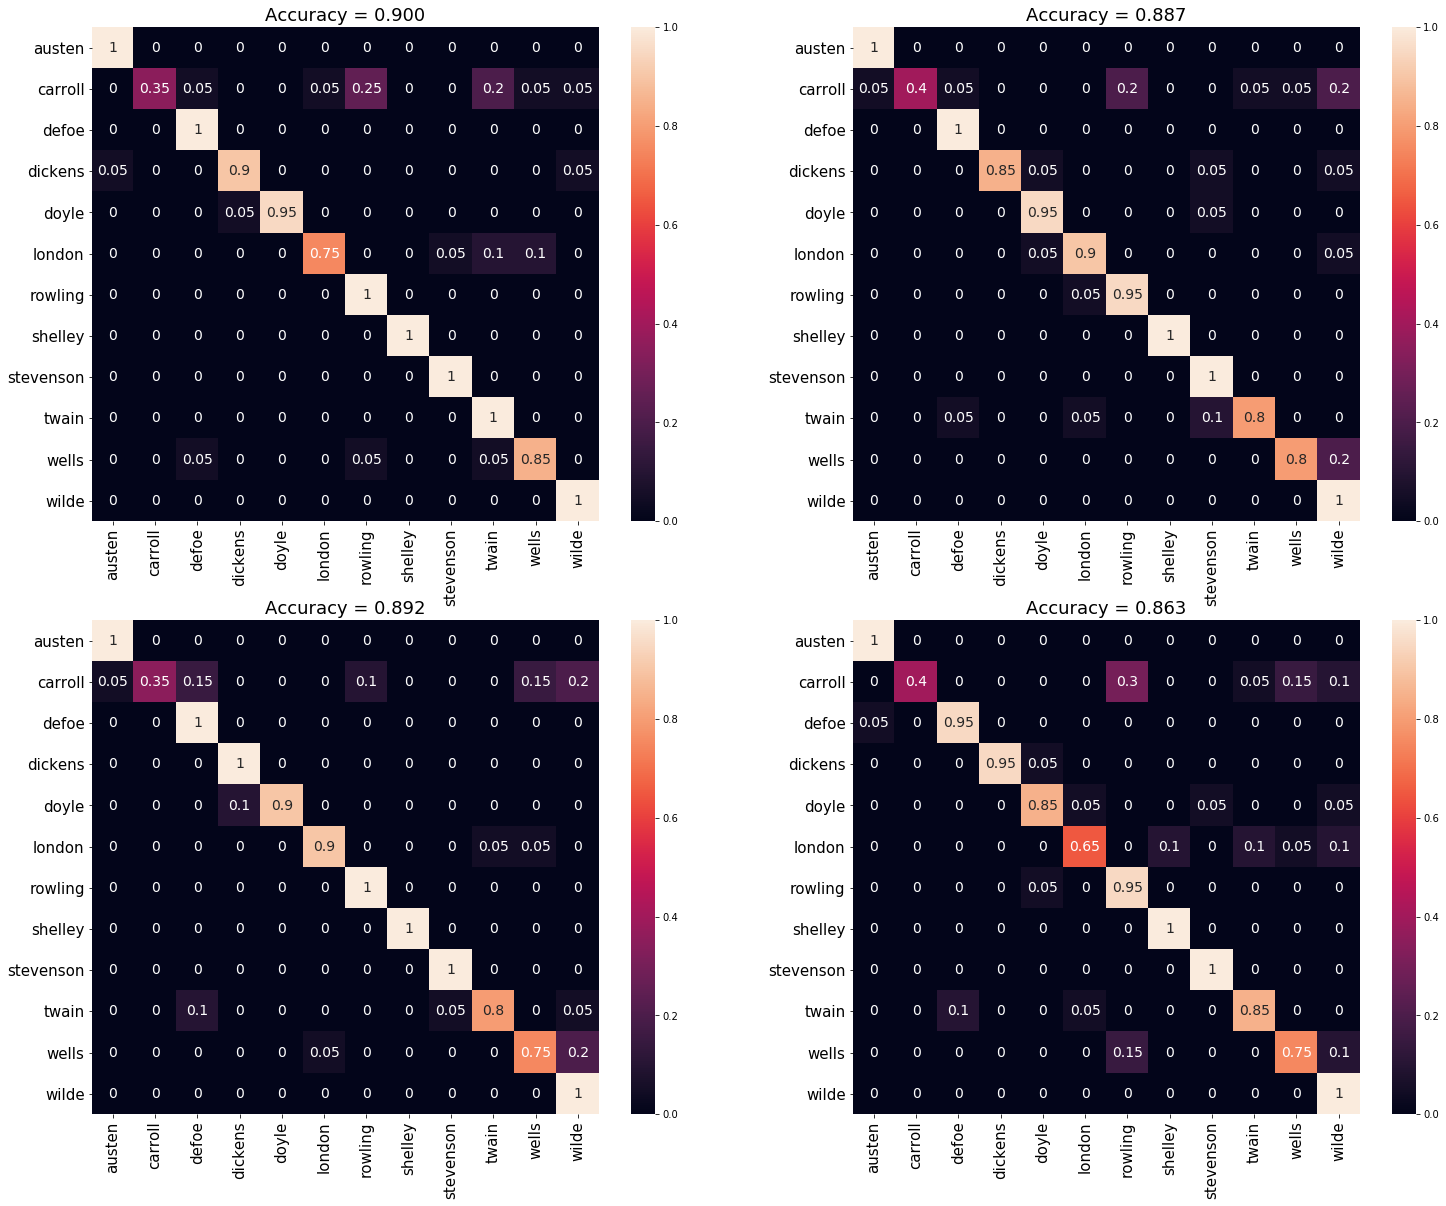

In [182]:
fig, ax = plt.subplots(2,2,figsize = (25,20),sharex=False,sharey=False)
auth_list = train_df['author'].unique()
print(auth_list)

for i in range(len(confusion_mat)):
    sns.heatmap(confusion_mat[i], annot=True, ax=ax[i//2, i%2], annot_kws={"fontsize":14})
    ax[i//2, i%2].xaxis.set_ticklabels(auth_list, rotation='vertical', fontsize=15)
    ax[i//2, i%2].yaxis.set_ticklabels(auth_list, rotation='horizontal', fontsize=15)
    ax[i//2, i%2].set_title("Accuracy = %.3f" %accuracy[i], fontsize=18)